In [1]:
import sys
sys.path.insert(0, "../../src/")
from framework import *
from algorithms import pso, differential_evolution, dual_annealing, mlsl, cmaes, nelder_mead_multi

save_handler = SaveHandlerJSON('../../result/june/')

best_instances = []

result_db_path = '../../result/june.db'

In [2]:
import importlib
import framework
importlib.reload(framework)
from framework import *

In [3]:
pso.load_best_instance(result_db_path)
ins = pso.best_instance
ins.load_results(save_handler=save_handler, partial=False)
best_instances.append((ins, ['population_size']))

In [4]:
differential_evolution.load_best_instance(result_db_path)
ins = differential_evolution.best_instance
ins.load_results(save_handler=save_handler, partial=False)
best_instances.append((ins, ['dithering', 'polish', 'popsize']))

In [5]:
dual_annealing.load_best_instance(result_db_path)
ins = dual_annealing.best_instance
ins.load_results(save_handler=save_handler, partial=False)
best_instances.append((ins, []))

In [6]:
mlsl.load_best_instance(result_db_path)
ins = mlsl.best_instance
ins.load_results(save_handler=save_handler, partial=False)
best_instances.append((ins, ['population']))

In [7]:
cmaes.load_best_instance(result_db_path)
cmaes.best_instance.load_results(save_handler=save_handler, partial=False)
best_instances.append((cmaes.best_instance, ['population_size']))

In [8]:
import optuna
# No hyper-param is needed for Nelder Mead
ins = AlgorithmInstance(algorithm=nelder_mead_multi, trial=optuna.trial.FixedTrial({}), instance_index=-1)
# nelder_mead_multi.load_best_instance(result_db_path)
ins.load_results(save_handler=save_handler, partial=False)
best_instances.append((ins, []))

PSO


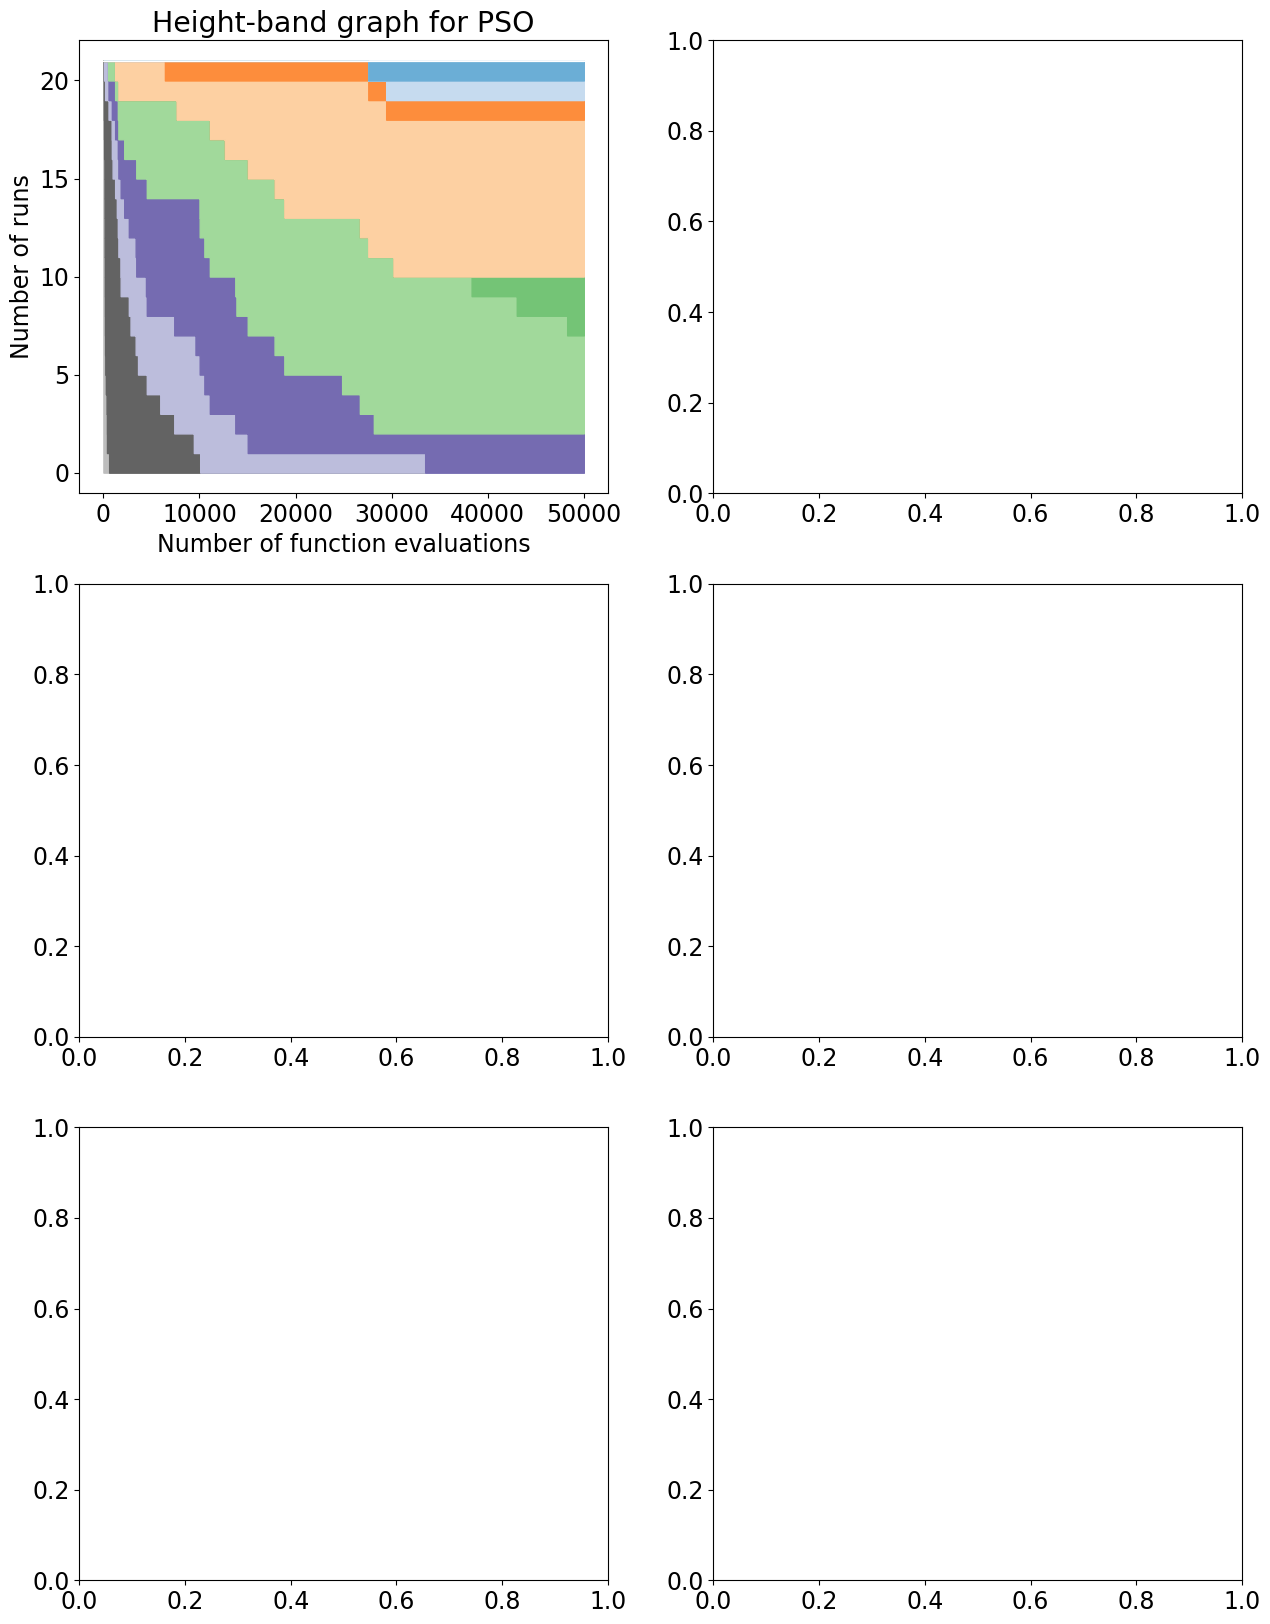

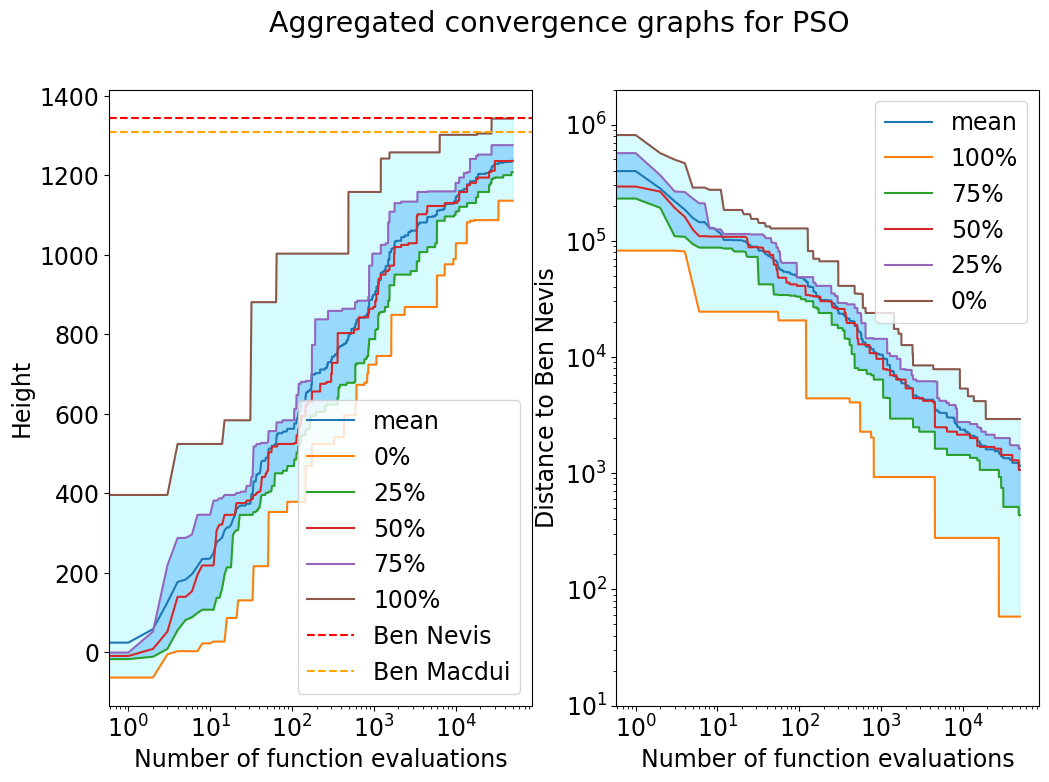

Differential Evolution


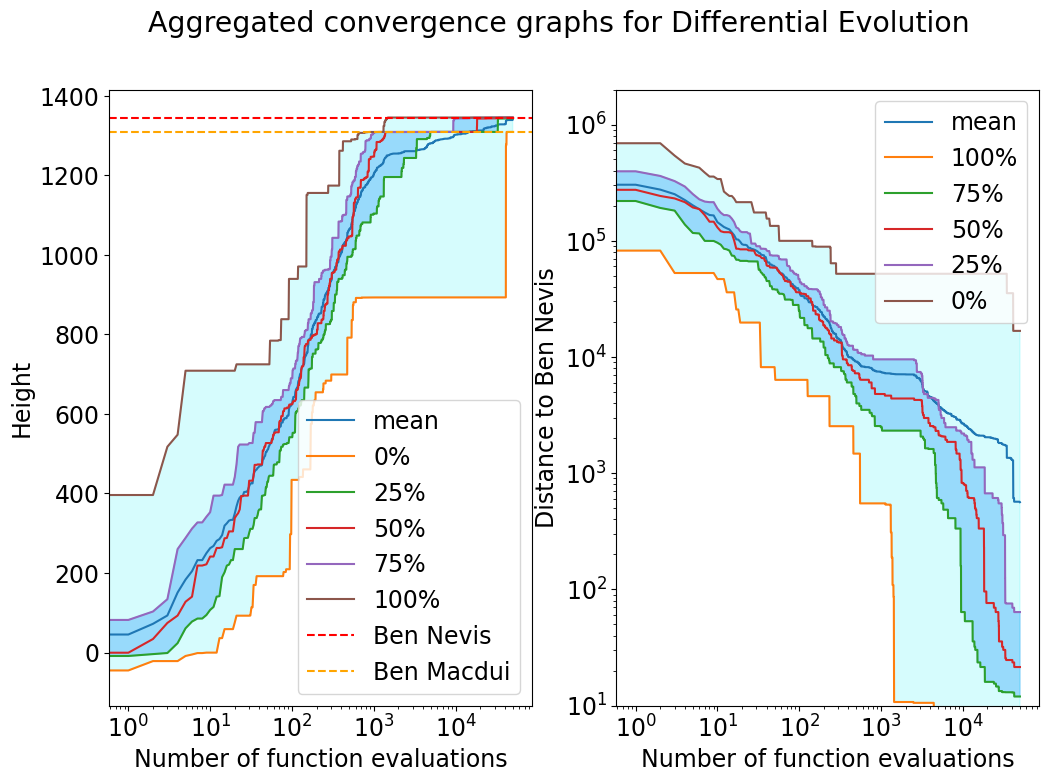

Dual Annealing


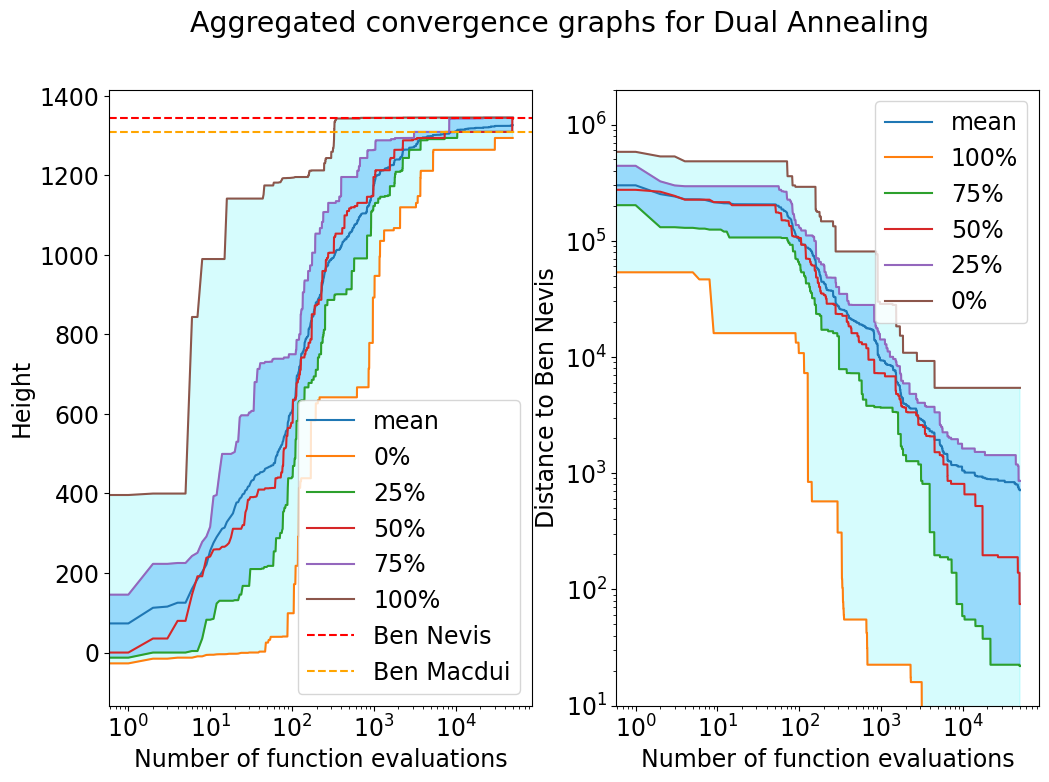

MLSL


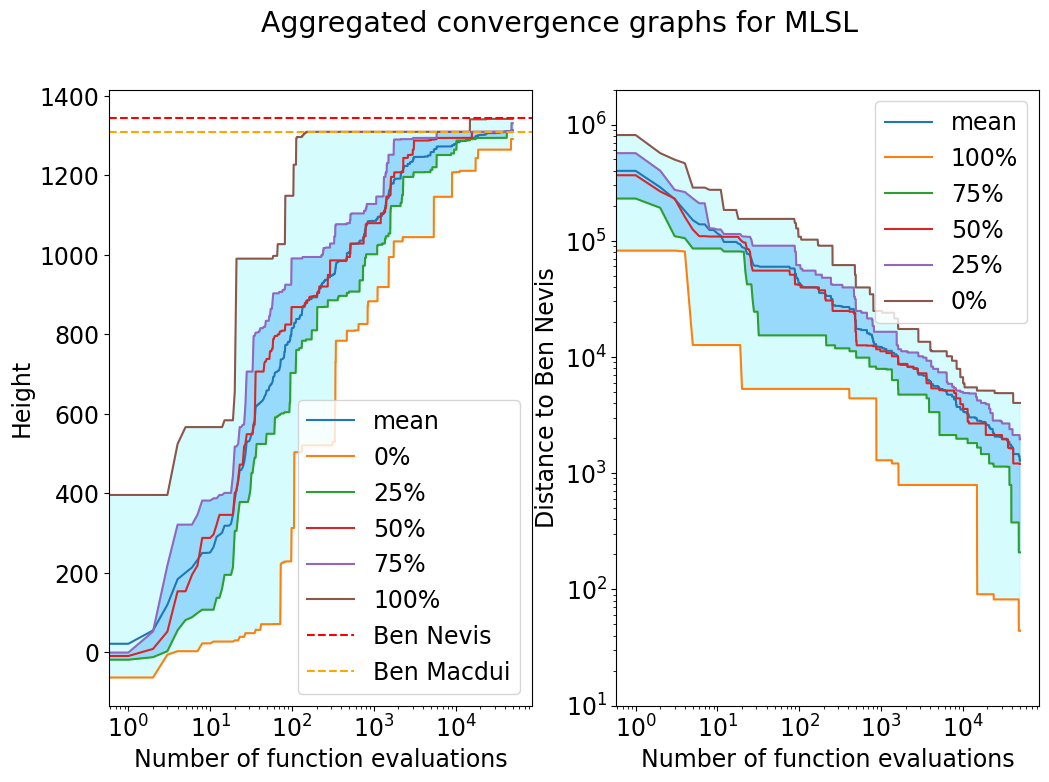

CMA-ES


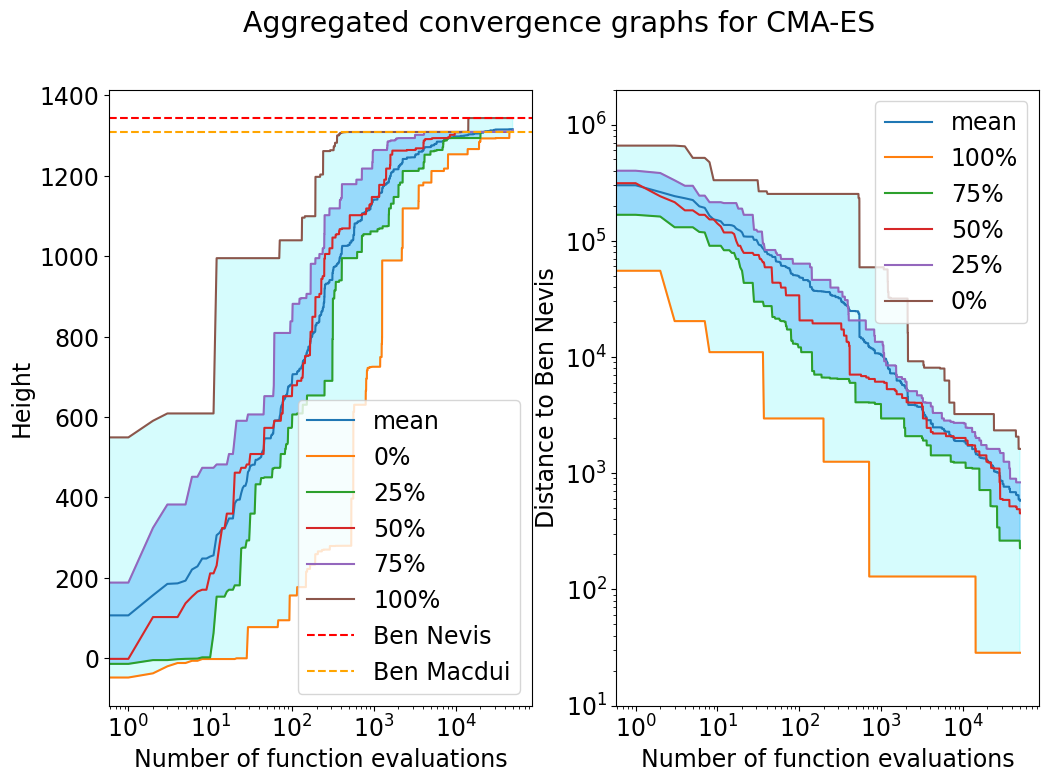

Nelder-Mead


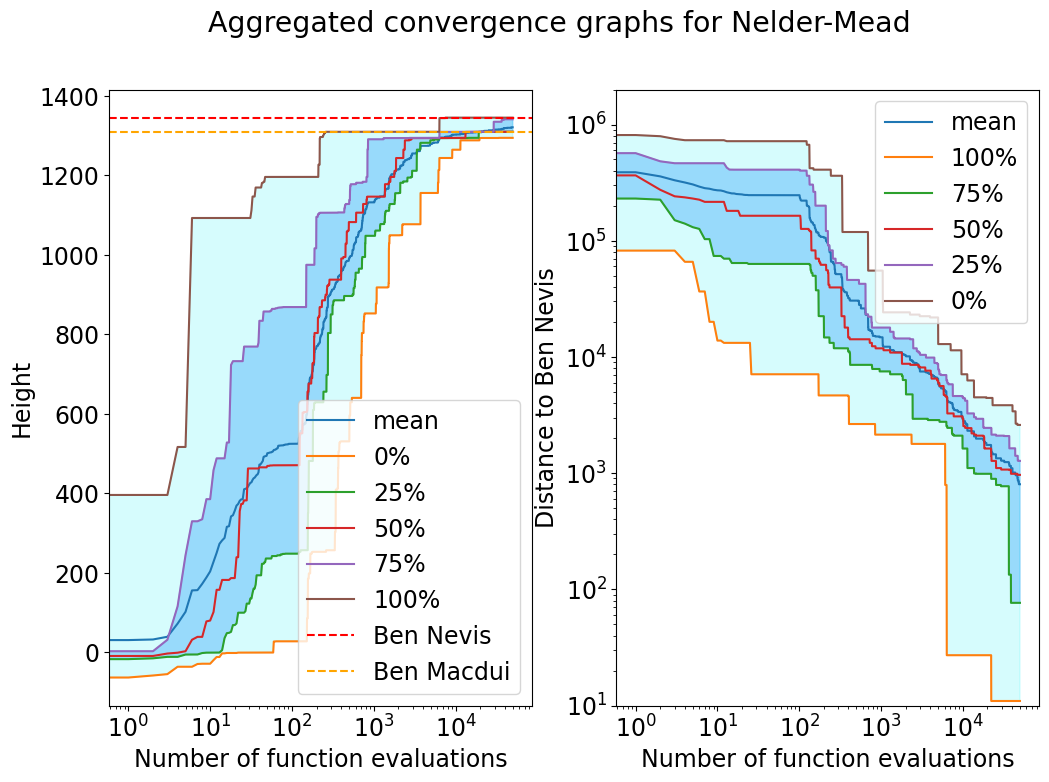

In [9]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})

fig_stack, axs_stack = plt.subplots(3, 2, figsize=(15, 20))
axs_stack = axs_stack.flatten()

performance_table = ''
param_table = ''

for i, (ins, int_fields) in enumerate(best_instances):
    ins: AlgorithmInstance
    name = ins.algorithm.name
    print(name)
    ins.cache_enabled = True
    param_table += ins.params_to_latex(int_fields=int_fields) + '\n'
    performance_table += ins.performance_to_latex() + '\n'
    ins.plot_convergence_graph(img_path=f'./imgs/agg-{name}.png')
    ins.plot_stacked_graph(mode='judge',
                           using_restart_results=False,
                           with_legends=False, 
                           fig=fig_stack, 
                           ax=axs_stack[i])
fig_stack.tight_layout(pad=2.0)
fig_stack.savefig('./imgs/combined-hb.png')

In [10]:
print(performance_table)

PSO	& 21	& 5\%	& 1236	& \(1.03 \times 10^{6}\) 	& \(2.63 \times 10^{4}\) \\
Differential Evolution	& 45	& 87\%	& 1340	& \(2.58 \times 10^{4}\) 	& \(2.47 \times 10^{3}\) \\
Dual Annealing	& 33	& 52\%	& 1326	& \(6.10 \times 10^{4}\) 	& \(4.80 \times 10^{3}\) \\
MLSL	& 22	& 18\%	& 1313	& \(2.55 \times 10^{5}\) 	& \(1.05 \times 10^{4}\) \\
CMA-ES	& 22	& 14\%	& 1316	& \(3.36 \times 10^{5}\) 	& \(1.02 \times 10^{4}\) \\
Nelder-Mead	& 24	& 25\%	& 1320	& \(1.73 \times 10^{5}\) 	& \(8.30 \times 10^{3}\) \\



In [11]:
print(param_table)

& \texttt{sigma0} & \(1.94 \times 10^{5}\) \\
& \texttt{r} & \(2.68 \times 10^{-1}\) \\
& \texttt{population\_size} & 124 \\

& \texttt{popsize} & 11 \\
& \texttt{recombination} & \(6.77 \times 10^{-1}\) \\
& \texttt{polish} & True \\
& \texttt{dithering} & True \\
& \texttt{mutation\_low} & \(7.50 \times 10^{-1}\) \\
& \texttt{mutation\_high} & \(9.18 \times 10^{-1}\) \\

& \texttt{initial\_temp} & \(2.69 \times 10^{4}\) \\
& \texttt{restart\_temp\_ratio} & \(1.49 \times 10^{-3}\) \\
& \texttt{visit} & \(2.47 \times 10^{0}\) \\
& \texttt{accept} & \(-3.42 \times 10^{0}\) \\

& \texttt{population} & 15 \\

& \texttt{sigma0} & \(3.09 \times 10^{5}\) \\
& \texttt{population\_size} & 10 \\





In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
def make_ert_plot(instances, styles):
    def get_result_success_eval(result, f_target):
        max_height = 0
        for i, h in enumerate(result.heights, 1):
            if i > MAX_FES:
                break
            max_height = max(h, max_height)
            if h >= f_target:
                return True, i

        return False, min(MAX_FES, result.len_points)
    
    def ert(instance, f_target):
        success_result_num = 0
        sum_eval_num = 0
        for result in instance.results:
            is_success, eval_num = get_result_success_eval(result, f_target)
            if is_success:
                success_result_num += 1
            sum_eval_num += eval_num
        
        if success_result_num == 0:
            return np.nan
        else:
            return sum_eval_num / success_result_num
    plt.figure(figsize=(8, 8)) 
    x = [1000, 1100, 1150, 1215, 1235, 1297, 1310, 1340]
    for ins, style in zip(instances, styles):
        y = [ert(ins, f_target) for f_target in x]
        plt.plot(x, y, linewidth=1.5, markersize=6, alpha=0.6, label=ins.algorithm.name, **style)
    
    plt.yscale('log') 
    plt.axvline(x=1340, color='gray', linestyle='--', linewidth=1)
    plt.text(1340, plt.ylim()[0] + 20, 'Ben Nevis', fontsize=12, rotation=90, va='bottom', ha='right', color='gray')
    plt.axvline(x=1297, color='gray', linestyle='--', linewidth=1)
    plt.text(1297, plt.ylim()[0] + 20, 'Ben Macdui', fontsize=12, rotation=90, va='bottom', ha='right', color='gray')
    plt.axvline(x=1235, color='gray', linestyle='--', linewidth=1)
    plt.text(1235, plt.ylim()[0] + 20, 'Cairngorm', fontsize=12, rotation=90, va='bottom', ha='right', color='gray')

    plt.legend()

    plt.xlabel('Target height (m)')
    plt.ylabel('ERT')
    plt.title(f'ERT vs. target height for the selected instance of each algorithm')
    plt.savefig('./imgs/output-ert.png')

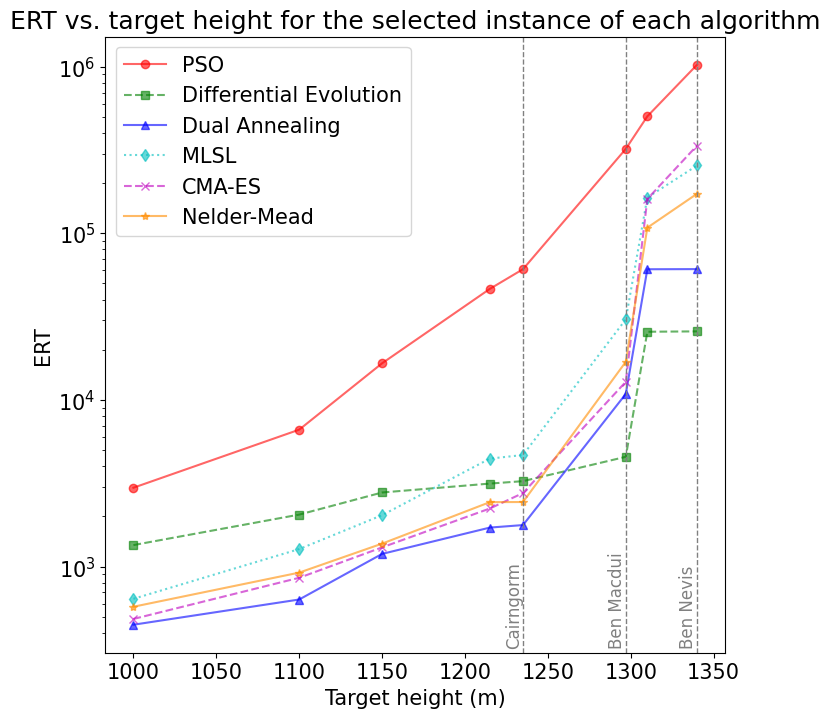

In [13]:
make_ert_plot([x for x, y in best_instances], 
    [
    {"marker": "o", "linestyle": "-", "color": "r"},  # Red line, solid, circle marker
    {"marker": "s", "linestyle": "--", "color": "g"},  # Green line, dashed, square marker
    {"marker": "^", "linestyle": "-", "color": "b"},  # Blue line, dash-dot, triangle marker
    {"marker": "d", "linestyle": ":", "color": "c"},  # Cyan line, dotted, diamond marker
    {"marker": "x", "linestyle": "--", "color": "m"},  # Magenta line, solid, x marker
    {"marker": "*", "linestyle": "-", "color": "#FF8C00"}  # Yellow line, dashed, star marker
])

In [14]:
# merging all aggregated convergence graphs into a big image
# this is because I am lazy and I don't want to attempt subplots within subplots

from PIL import Image

algorithm_names = [
    "PSO",
    'Differential Evolution',
    'Dual Annealing',
    'MLSL',
    'CMA-ES',
    'Nelder-Mead',
]
image_paths = [
    f'./imgs/agg-{name}.png' for name in algorithm_names
]
# Open images and store them in a list
images = [Image.open(image_path) for image_path in image_paths]

# Assuming all images are the same size
image_width, image_height = images[0].size

# Define padding size (in pixels)
padding = 20

# Calculate the size of the final combined image including padding
combined_width = 2 * image_width + padding
combined_height = 3 * image_height + 2 * padding

# Create a blank image with the correct size
combined_image = Image.new('RGB', (combined_width, combined_height), color=(255, 255, 255))

# Paste each image into the correct position with padding
for i, image in enumerate(images):
    x_offset = (i % 2) * (image_width + padding)
    y_offset = (i // 2) * (image_height + padding)
    combined_image.paste(image, (x_offset, y_offset))

# Save or show the combined image
combined_image.save('./imgs/combined-agg.png')
combined_image.show()

PSO


Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
No applications found for mimetype: image/png
./usr/bin/xdg-open: 882: x-www-browser: not found
/usr/bin/xdg-open: 882: firefox: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: seamonkey: not found
/usr/bin/xdg-open: 882: mozilla: not found
/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: google-chrome: not found
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method avai

Differential Evolution
Dual Annealing
MLSL
CMA-ES
Nelder-Mead


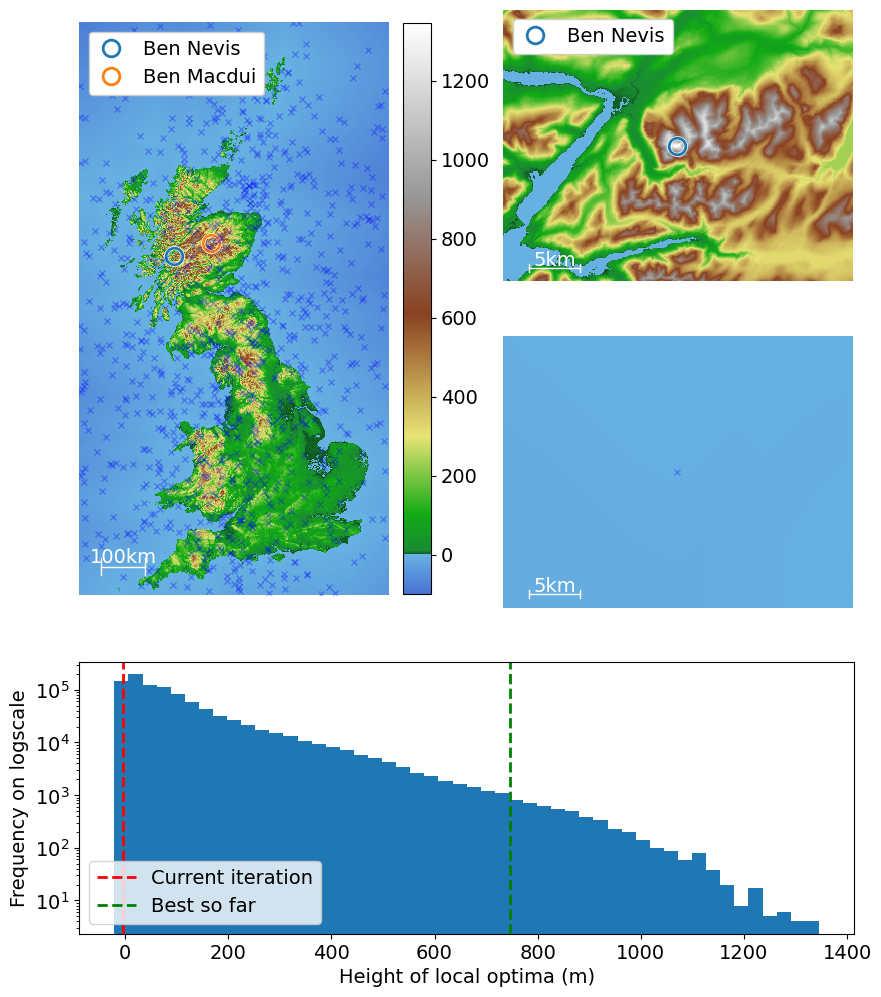

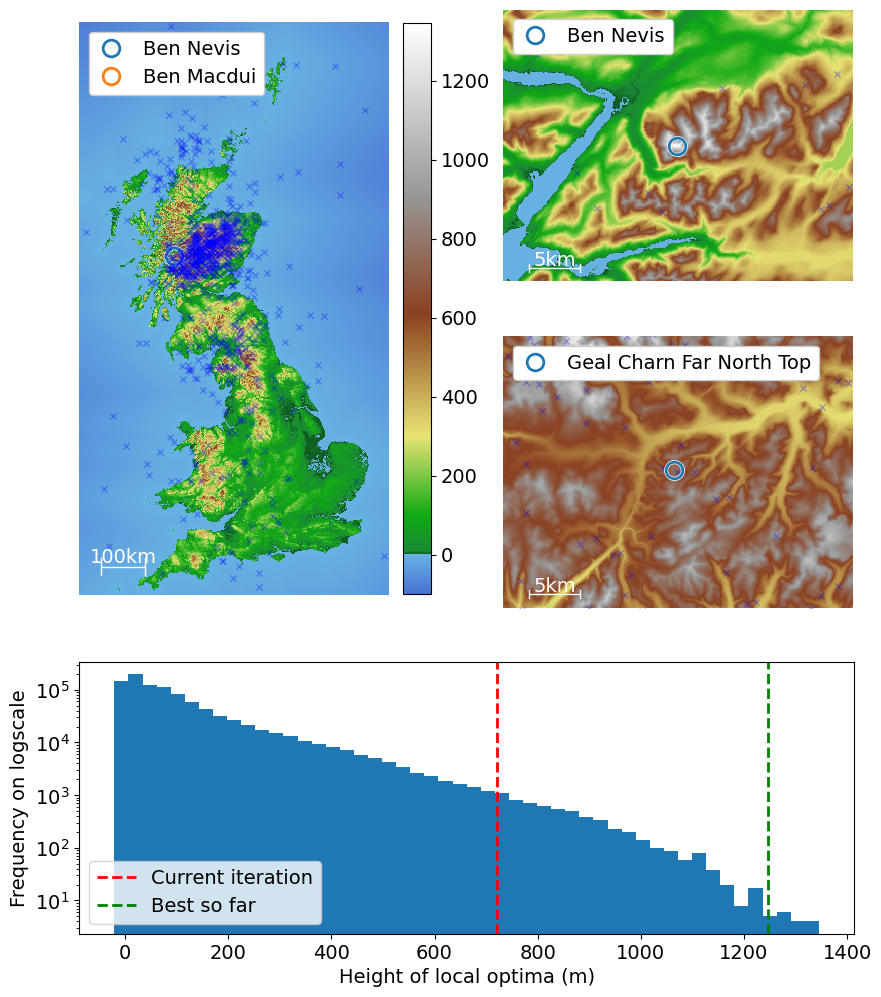

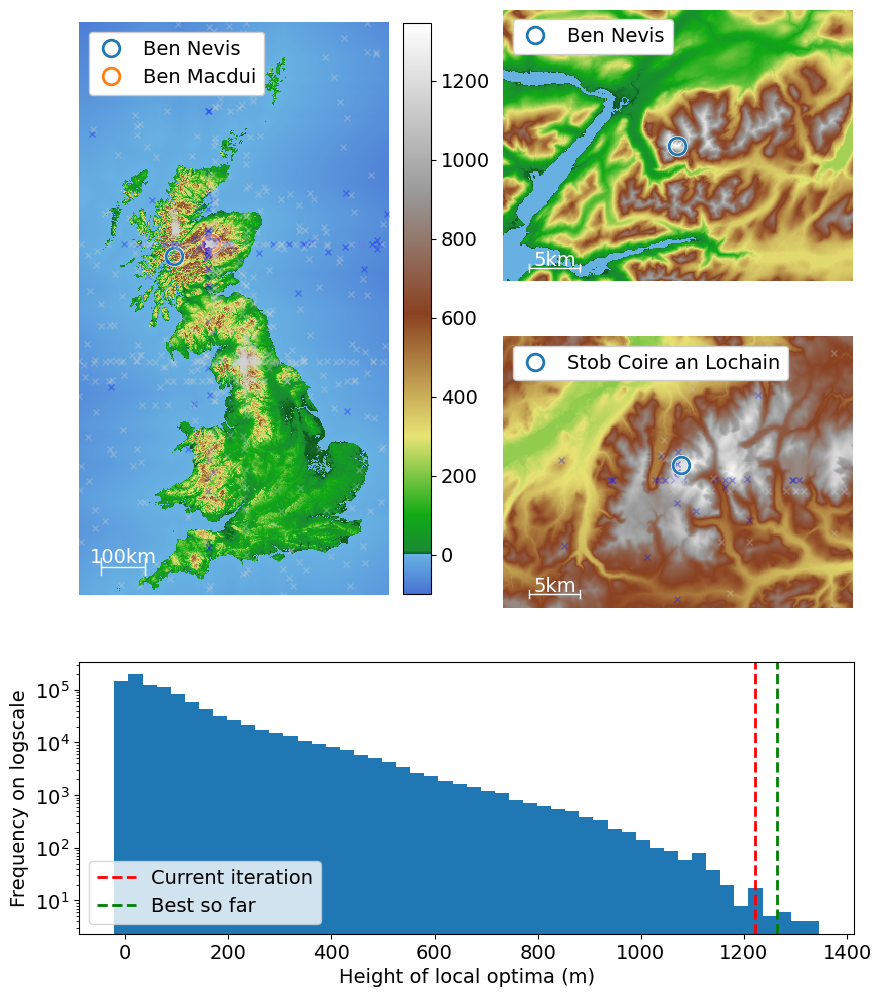

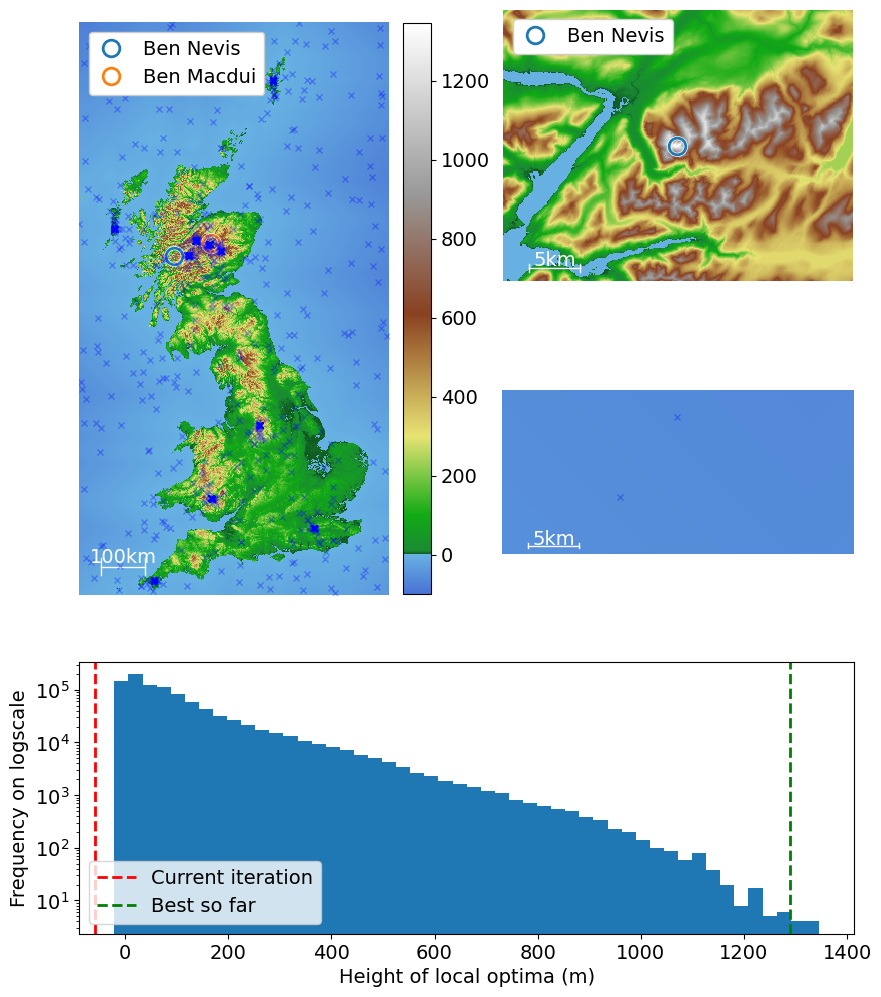

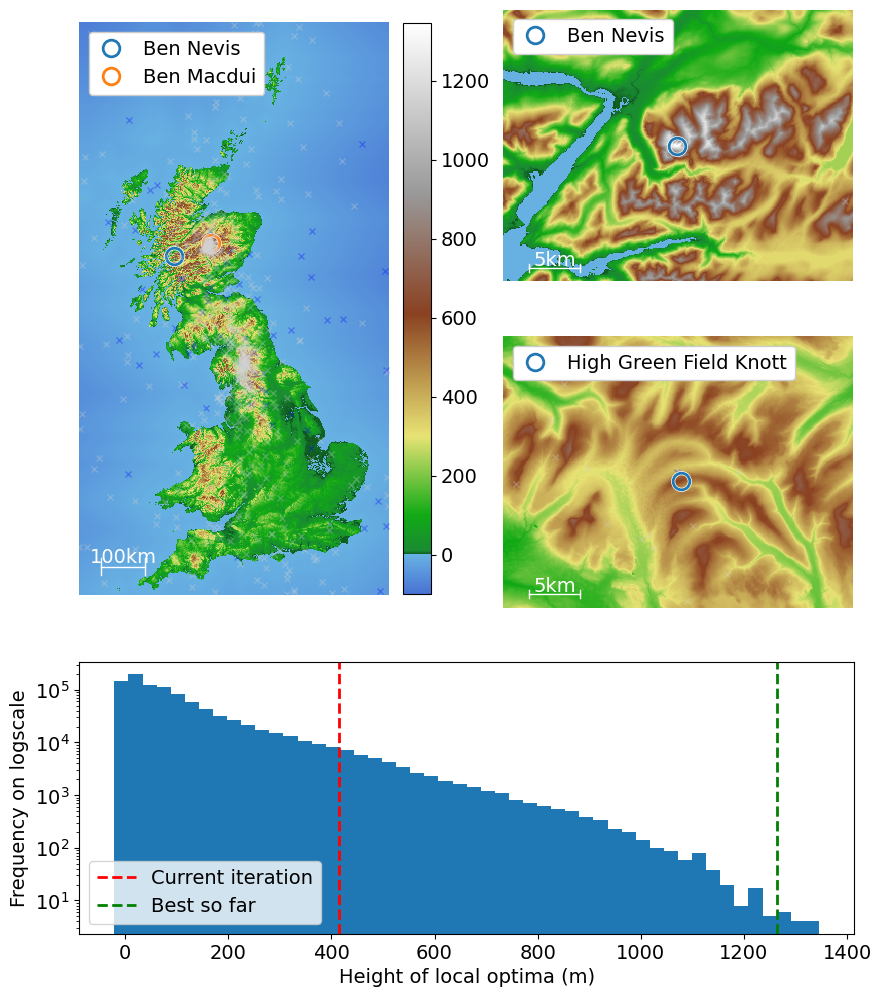

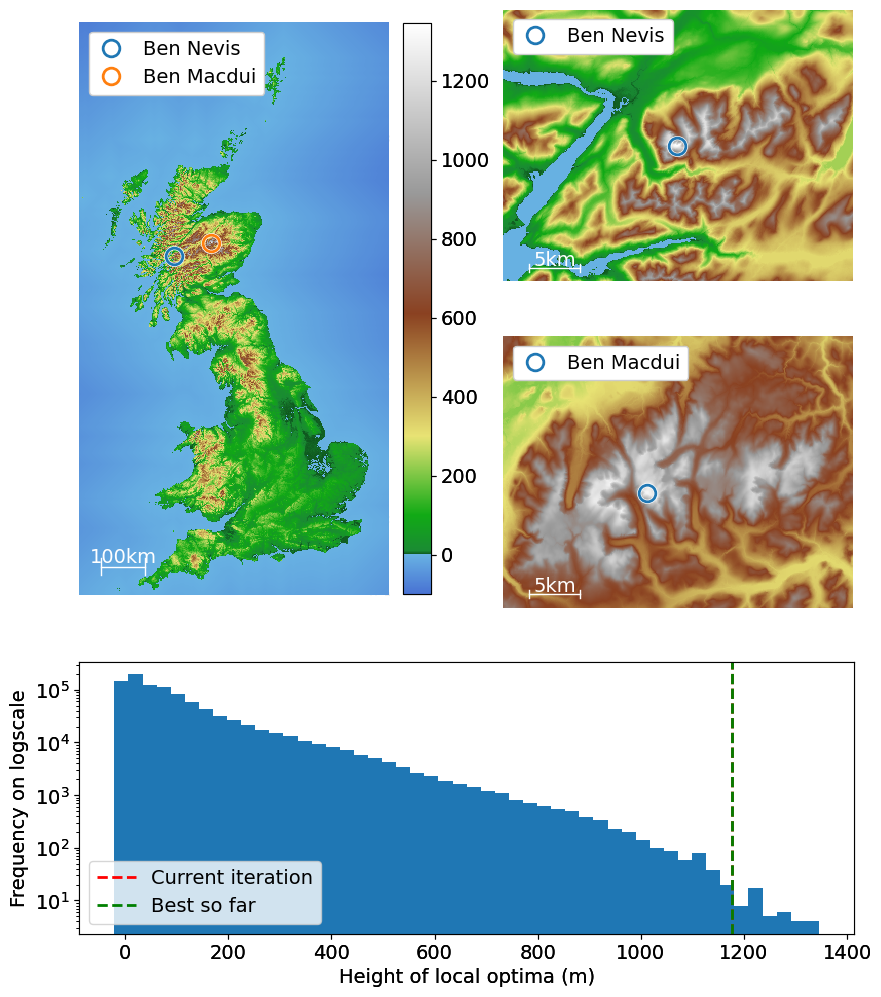

In [15]:
# produce some sample animations for each algorithm
import numpy as np
maxima_heights = np.load('../../basin-problem/res/maxima_heights.npy')
for i, (ins, int_fields) in enumerate(best_instances):
    ins: AlgorithmInstance
    print(ins.algorithm.name)
    res = ins.results[0]
    anim = framework.ResultAnimation(res, maxima_heights, mode='evaluations', frame_num=1000)
    anim.save(f'./animation/{ins.algorithm.name}.mp4', fps=5)